In [1]:
import torch

import lightning as L
import matplotlib.pyplot as plt

from PIL import Image
from diffusers import DDPMScheduler
from datasets import load_dataset
from torchvision import transforms
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

from TL.generation import Tempering

In [2]:
image_size = 32
train_batch_size = 32
T = 100
num_epochs = T
learning_rate = 1e-4
lr_warmup_steps = 100

In [3]:
dataset = load_dataset(
    "huggan/smithsonian_butterflies_subset", 
    split="train", 
    cache_dir="./cache"
)

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

sample_image = dataset[0]["images"].unsqueeze(0)

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
train_dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=train_batch_size, 
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [5]:
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64, 64, 128, 128),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 7126275


In [6]:
model.sample_size


32

In [7]:
noise_scheduler = DDPMScheduler(num_train_timesteps=T)

In [8]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate
)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [9]:
tlmodel = Tempering(
    model=model,
    noise_scheduler=noise_scheduler,
    num_training_samples=len(train_dataloader),
    MC_steps=10,
    burn_in_fraction=0.2,
    m=2
)

print ("number of training epochs:", num_epochs)
print ("T:", T)
print ("number of MC steps: ", tlmodel.MC_steps)
print ("number of burn-in steps: ", tlmodel.burn_in_steps)
print ("number of MC samples: ", tlmodel.n_MC)
print ("number of MC samples used for training: ", tlmodel.m)

number of training epochs: 100
T: 100
number of MC steps:  10
number of burn-in steps:  2
number of MC samples:  8
number of MC samples used for training:  2


In [12]:
import torchvision
images = tlmodel.generate_samples(10)
images = (images / 2 + 0.5).clamp(0, 1).squeeze()
grid = torchvision.utils.make_grid(images, nrow=5)
images = (grid.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = Image.fromarray(images)    
images.save("images.png")

In [17]:
tlmodel.device

device(type='cpu')

In [10]:
trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    precision=32,
    fast_dev_run=False
)
trainer.fit(tlmodel, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\mingx\anaconda3\envs\mingxuan\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#tor

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\mingx\anaconda3\envs\mingxuan\Lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [19]:
pure_noise = torch.randn_like(sample_image)
denoised_image = tlmodel.model(pure_noise, 100).sample

In [14]:
image = (denoised_image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
# save image
image.save("denoised_image.png")

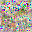

In [20]:
Image.fromarray(((denoised_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])